In [1]:
import glob
import matplotlib.image as mpimg
import imageio as im
from tensorflow.keras import models
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import save_model, load_model
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Conv2D, Flatten, Dense, MaxPool2D
import numpy as np
from tensorflow.python.keras.preprocessing import image
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
print(tf.__version__)

2.2.0


In [27]:
CNNDetectionmodel = load_model('models/CNNmodel.h5')
CNNDetectionmodel.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
CNNDetectionmodel.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)            

In [ ]:
# Import image
img_path = "data/test/img_align_celeba/180002.jpg"

img = image.load_img(img_path, target_size=(128, 128))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

plt.imshow(img_tensor[0])
plt.show()

print(img_tensor.shape)

In [ ]:
# Extracts the outputs of the top 9 layers
layer_outputs = [layer.output for layer in CNNDetectionmodel.layers[:9]]

# Creates a model that will return these outputs, given the model input
activation_model = models.Model(inputs=CNNDetectionmodel.input, outputs=layer_outputs) 

# Returns a list of five Numpy arrays: one array per layer activation
activations = activation_model.predict(img_tensor) 

first_layer_activation = activations[0]
print(first_layer_activation.shape)

In [ ]:
plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')

In [ ]:
layer_names = []
for layer in CNNDetectionmodel.layers[:6]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot

images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                            :, :,
                                            col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                        row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [17]:
def plot_CNN_image_layers(input_image_path):

    # Import image

    img = image.load_img(img_path, target_size=(128, 128))
    img_tensor = image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor /= 255.

    plt.imshow(img_tensor[0])
    plt.show()

    print(img_tensor.shape)
    
    # Import CNN Model
    
    CNNDetectionmodel = load_model('models/CNNmodel.h5')

    # Predict Image

    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    classes = CNNDetectionmodel.predict(images, batch_size=1)
    percentage = CNNDetectionmodel.predict(img_tensor, batch_size=1)

    print("0 is Fake, 1 is Real")
    print("Predicted class is:",classes)
    print(percentage)

    # Extract image layers

    # Extracts the outputs of the top 9 layers
    layer_outputs = [layer.output for layer in CNNDetectionmodel.layers[:9]]

    # Creates a model that will return these outputs, given the model input
    activation_model = models.Model(inputs=CNNDetectionmodel.input, outputs=layer_outputs) 

    # Returns a list of five Numpy arrays: one array per layer activation
    activations = activation_model.predict(img_tensor) 

    first_layer_activation = activations[0]
    print(first_layer_activation.shape)

    # Plot image layers

    layer_names = []
    for layer in CNNDetectionmodel.layers[:6]:
        layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot

    images_per_row = 16

    for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
        n_features = layer_activation.shape[-1] # Number of features in the feature map
        size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
        n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        for col in range(n_cols): # Tiles each filter into a big horizontal grid
            for row in range(images_per_row):
                channel_image = layer_activation[0,
                                                :, :,
                                                col * images_per_row + row]
                channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size, # Displays the grid
                            row * size : (row + 1) * size] = channel_image
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                                scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [52]:
def prediction_bins(prediction_results):

    fake_50 = 0
    fake_55 = 0
    fake_60 = 0
    fake_65 = 0
    fake_70 = 0
    fake_75 = 0
    fake_80 = 0
    fake_85 = 0
    fake_90 = 0
    fake_95 = 0
    fake_100 = 0
    real_50 = 0

    for score in prediction_results:
        if score >= 1: fake_100 = fake_100 + 1
        elif score >= 0.95: fake_95 = fake_95 + 1
        elif score >= 0.90: fake_90 = fake_90 + 1
        elif score >= 0.85: fake_85 = fake_85 + 1
        elif score >= 0.80: fake_80 = fake_80 + 1
        elif score >= 0.75: fake_75 = fake_75 + 1
        elif score >= 0.70: fake_70 = fake_70 + 1
        elif score >= 0.65: fake_65 = fake_65 + 1
        elif score >= 0.60: fake_60 = fake_60 + 1  
        elif score >= 0.55: fake_55 = fake_55 + 1
        elif score >= 0.50: fake_50 = fake_50 + 1  
        else : real_50 = real_50 + 1

    print(
    real_50, fake_50, fake_55, fake_60, fake_65, fake_70, 
    fake_75, fake_80, fake_85, fake_90, fake_95, fake_100)

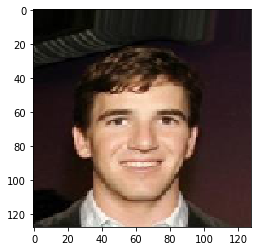

(1, 128, 128, 3)
0 is Fake, 1 is Real
Predicted class is: [[1.]]
[[0.5295288]]
(1, 126, 126, 32)


/home/matthew/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in true_divide


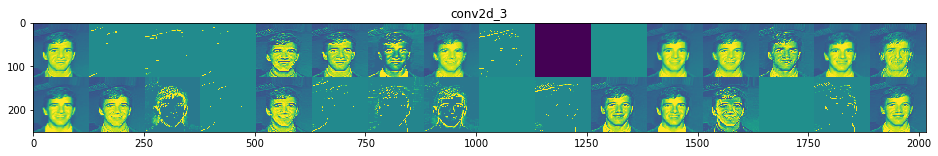

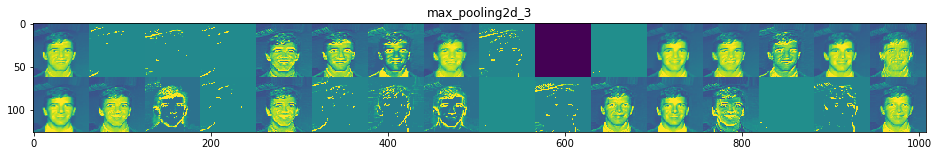

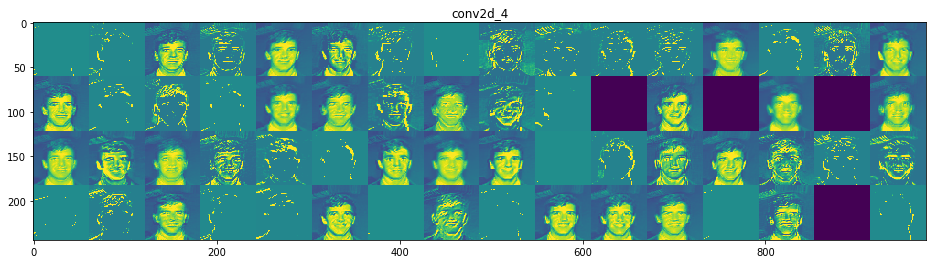

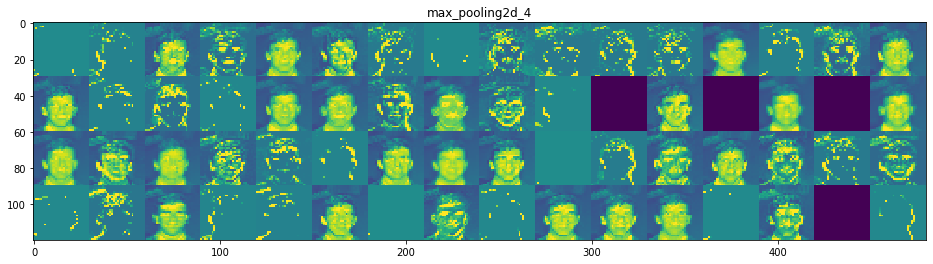

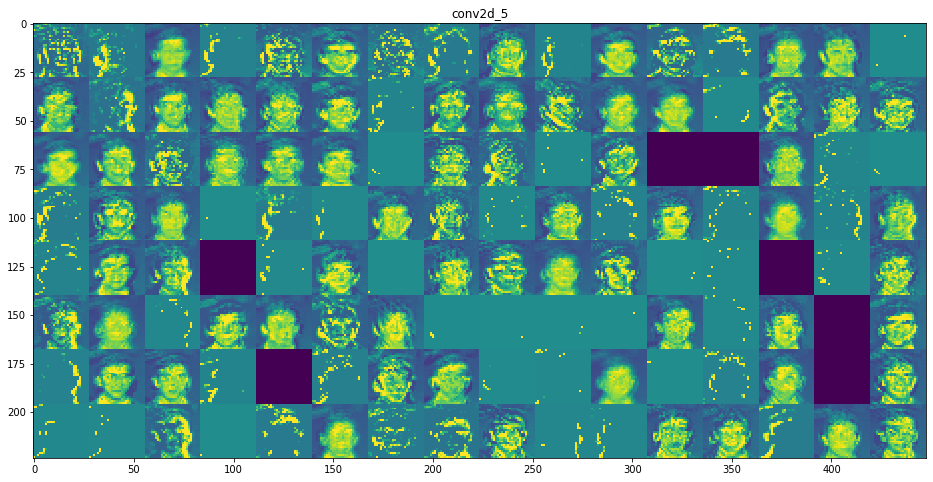

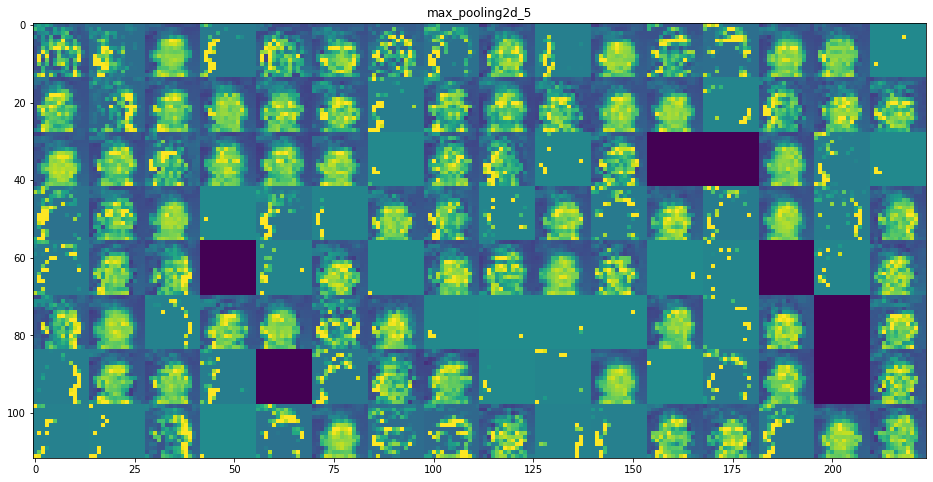

In [18]:
img_path = "data/test/img_align_celeba/180002.jpg"
plot_CNN_image_layers(img_path)

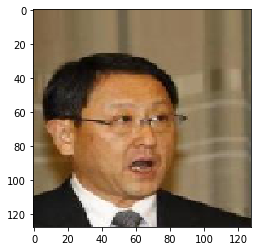

(1, 128, 128, 3)
0 is Fake, 1 is Real
Predicted class is: [[1.]]
[[0.5401006]]
(1, 126, 126, 32)


/home/matthew/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in true_divide


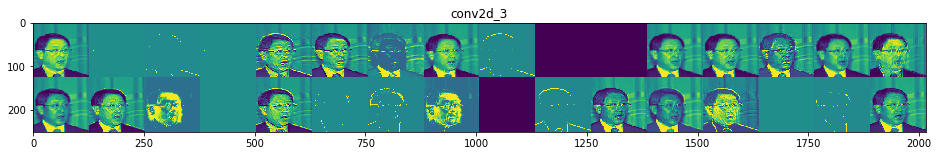

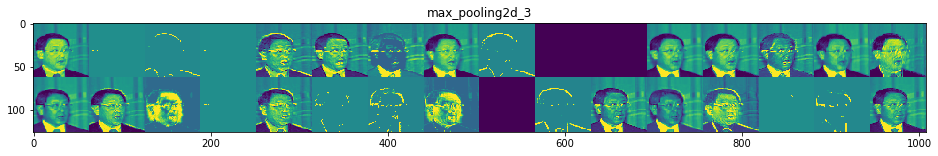

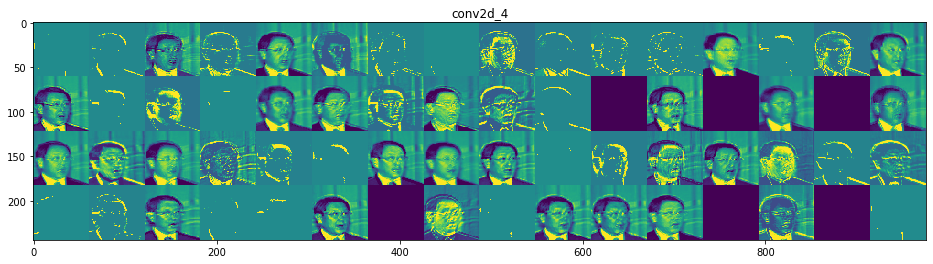

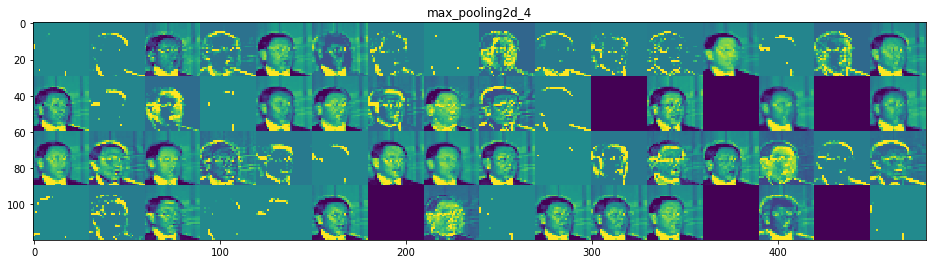

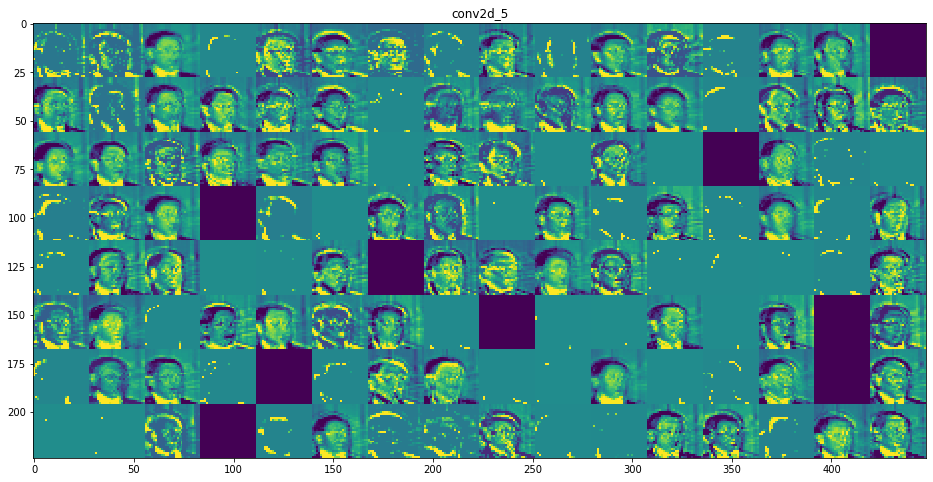

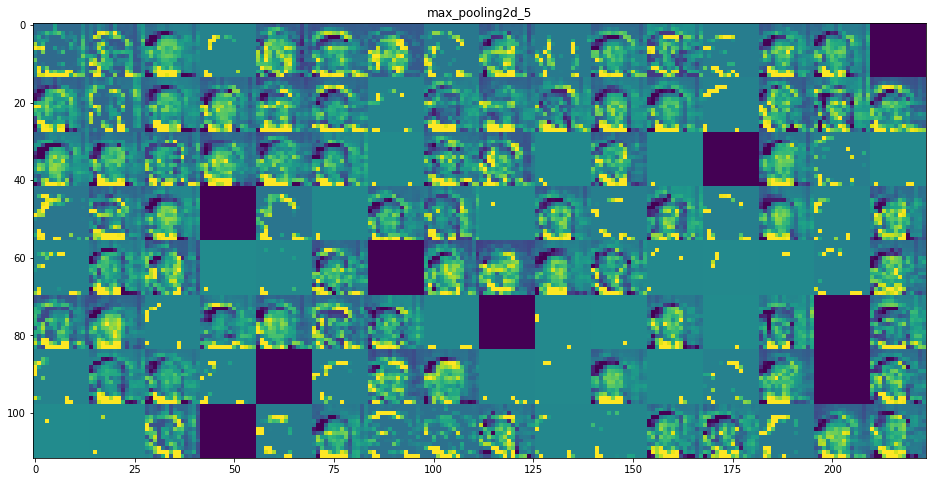

In [19]:
img_path = "data/test/img_align_celeba/180004.jpg"
plot_CNN_image_layers(img_path)

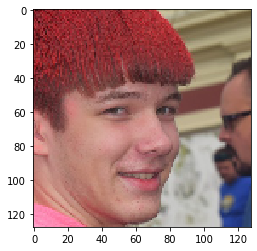

(1, 128, 128, 3)
0 is Fake, 1 is Real
Predicted class is: [[1.]]
[[0.5376146]]
(1, 126, 126, 32)


/home/matthew/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in true_divide


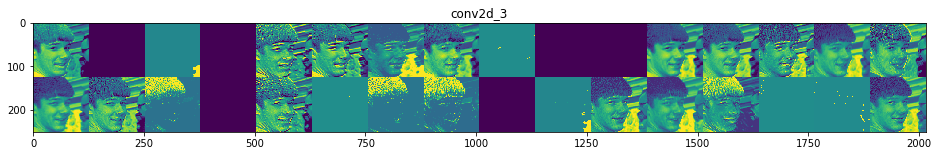

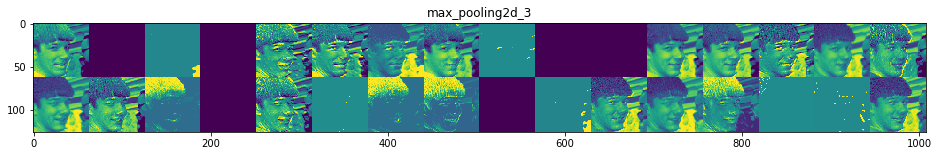

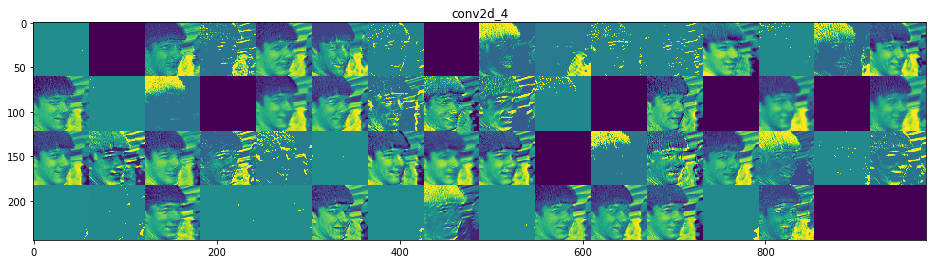

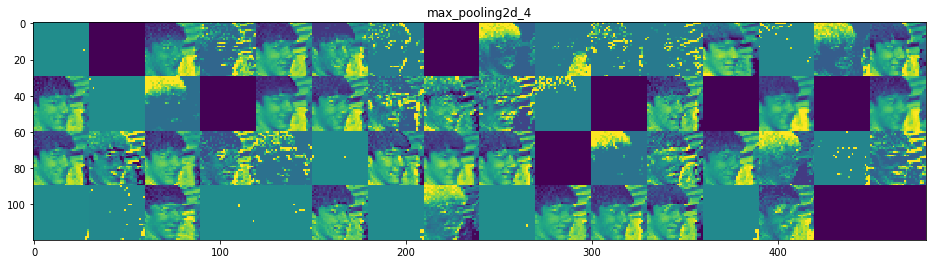

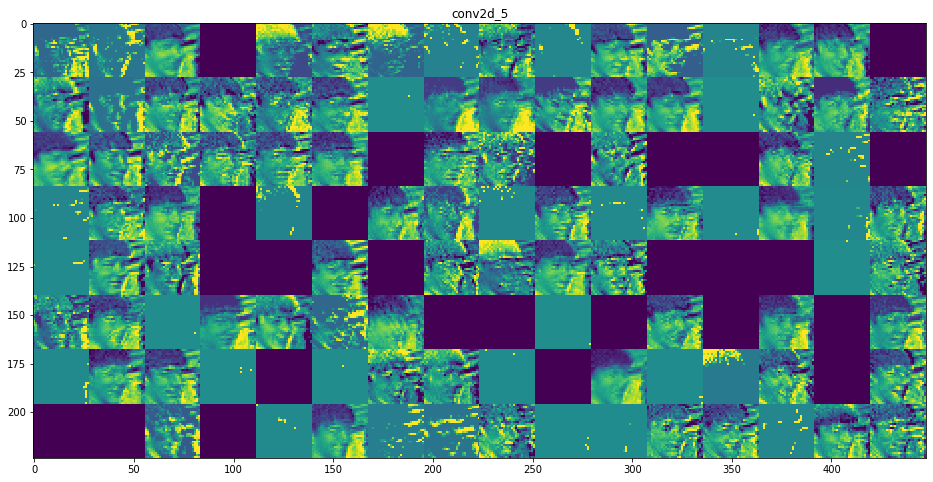

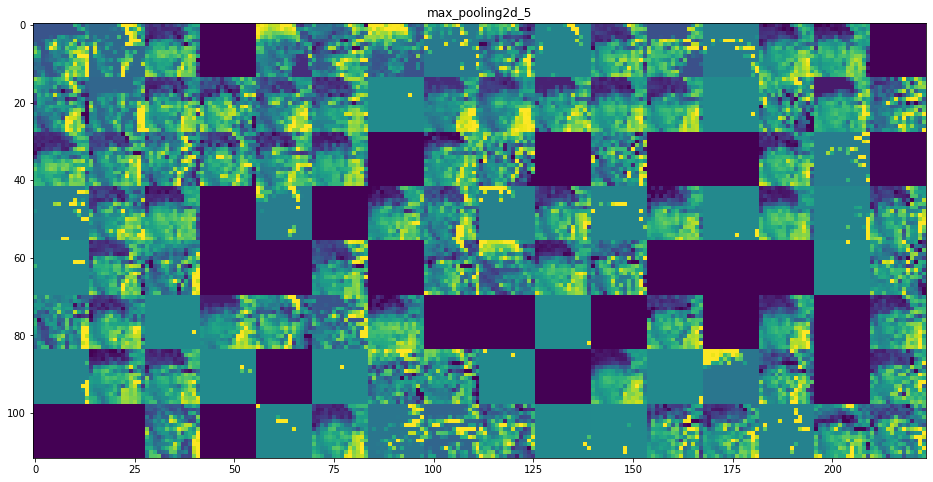

In [20]:
img_path = "data/test/fakeFaces/63000.jpg"
plot_CNN_image_layers(img_path)

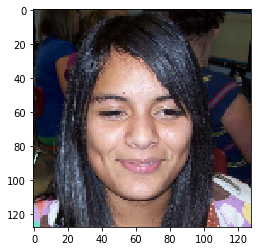

(1, 128, 128, 3)
0 is Fake, 1 is Real
Predicted class is: [[1.]]
[[0.5304095]]
(1, 126, 126, 32)


/home/matthew/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in true_divide


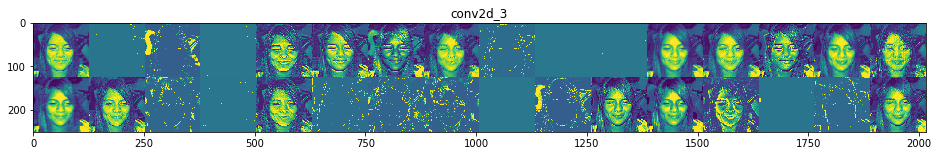

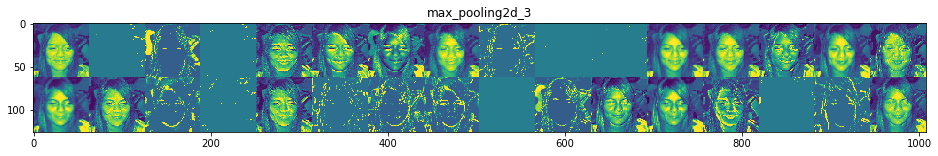

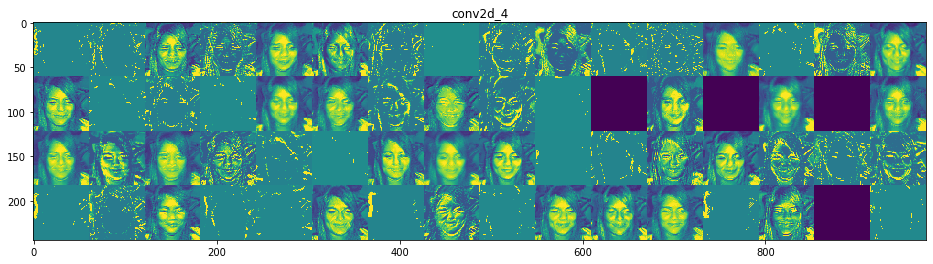

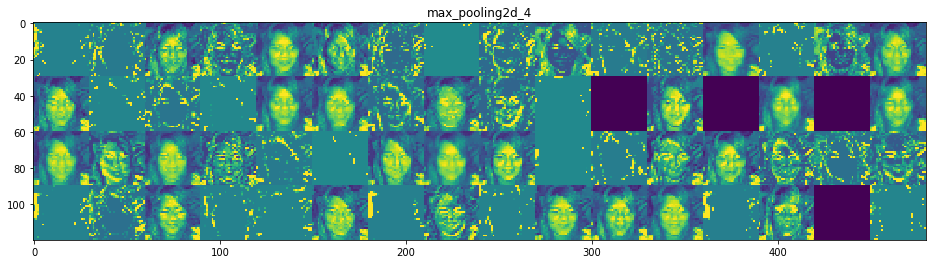

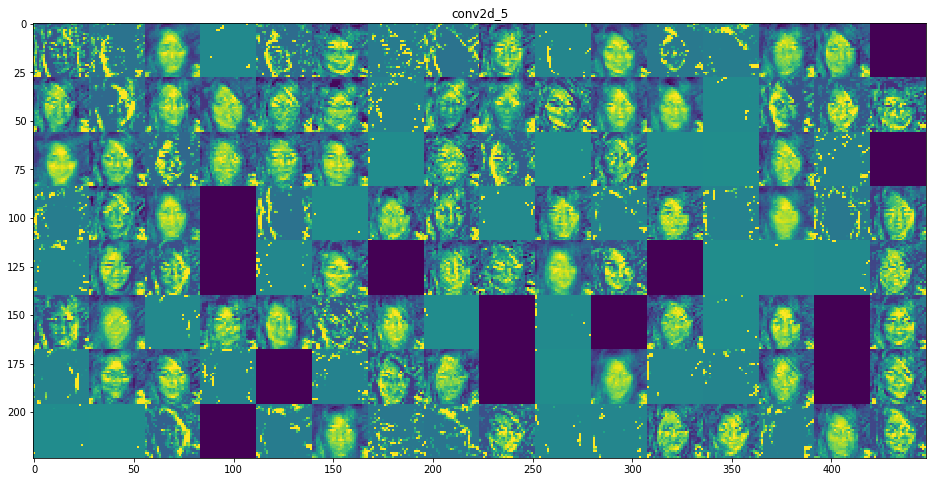

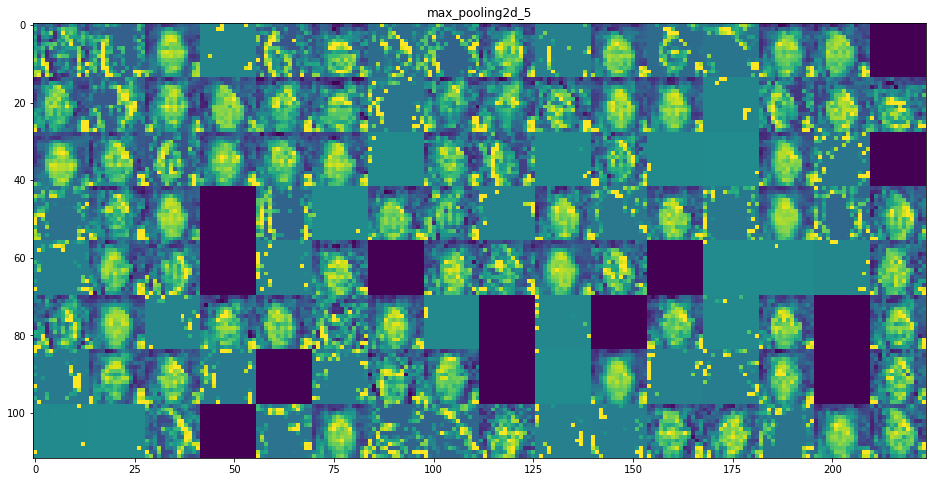

In [21]:
img_path = "data/test/fakeFaces/63001.jpg"
plot_CNN_image_layers(img_path)

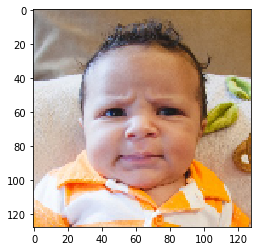

(1, 128, 128, 3)
0 is Fake, 1 is Real
Predicted class is: [[1.]]
[[0.5465174]]
(1, 126, 126, 32)


/home/matthew/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in true_divide


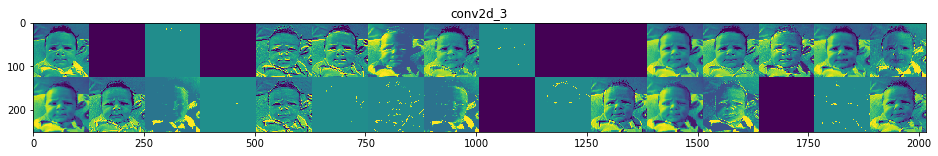

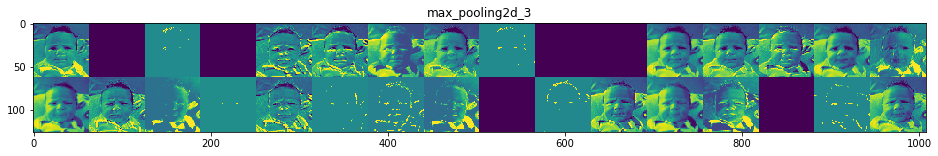

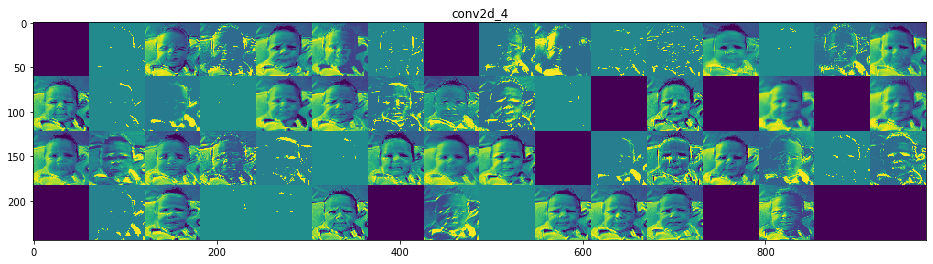

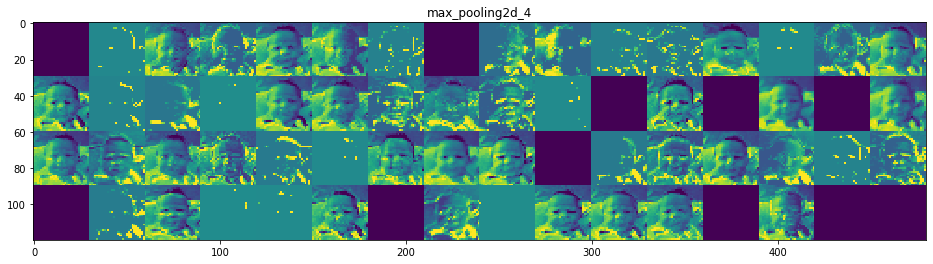

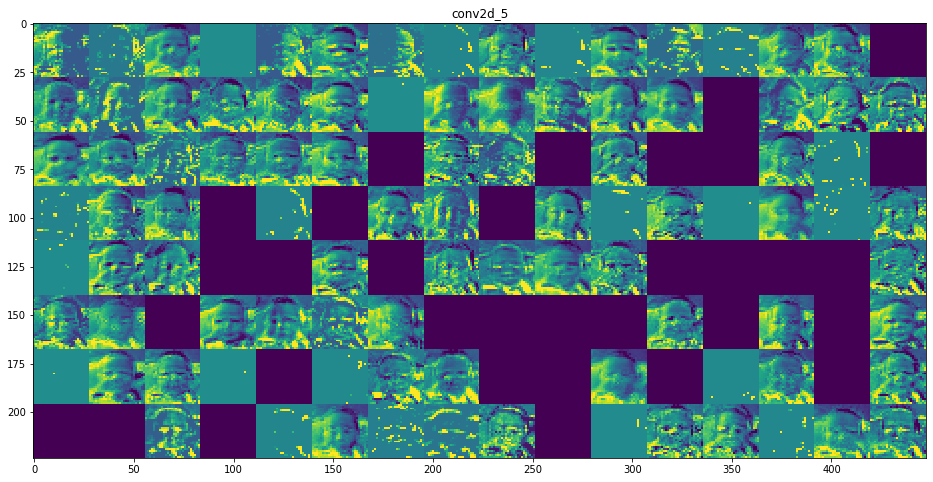

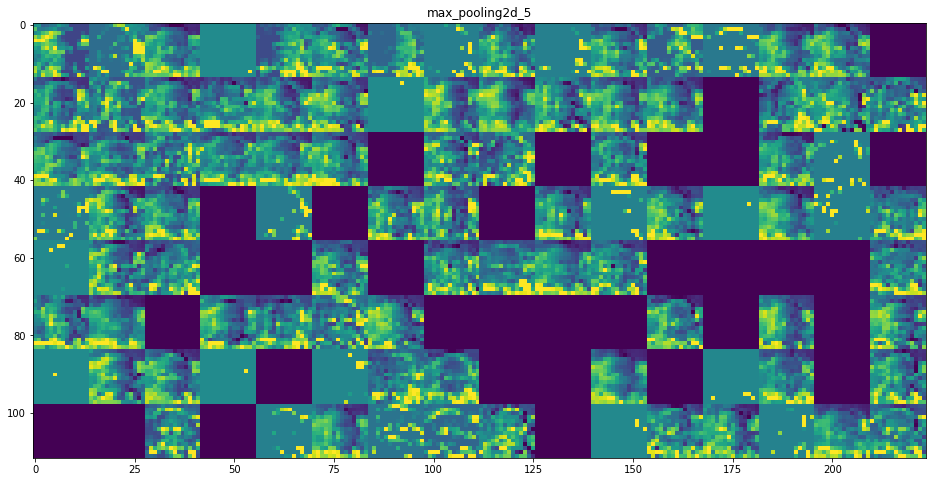

In [22]:
img_path = "data/test/fakeFaces/63002.jpg"
plot_CNN_image_layers(img_path)

# Feature Extraction Analysis
Rermoving layer to see the effect

In [55]:
CNNDetectionmodel.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)            

In [42]:
from tensorflow.keras.models import Model

CNNDetectionmodel.layers.pop() 
model2 = Model(CNNDetectionmodel.input, CNNDetectionmodel.layers[-1].output)
model2.summary()


Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3_input (InputLayer)  [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 128)       0  

In [44]:
model2 = Model(CNNDetectionmodel.input, CNNDetectionmodel.layers[-2].output)
model2.summary()

Model: "model_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3_input (InputLayer)  [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 128)       0  

# Evaluation of a Dataset - Test Set

In [ ]:
validation_set = validation_datagen.flow_from_directory('data/test',
                                            target_size=(128,128),
                                            batch_size =nbatch,
                                            class_mode = 'binary')

In [ ]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = CNNDetectionmodel.evaluate(validation_set, batch_size=128)
print("test loss, test acc:", results)

In [53]:
def evaluate_on_test_data(test_dataset_path, model_to_evaluate):
    
    validation_datagen = ImageDataGenerator(rescale = 1./255)
    
    nbatch = 128
    
    validation_set = validation_datagen.flow_from_directory(test_dataset_path,
                                            target_size=(128,128),
                                            batch_size =nbatch,
                                            class_mode = 'binary')
    # Evaluate the model on the test data using `evaluate`
    print("Evaluate on test data")
    results = model_to_evaluate.evaluate(validation_set, batch_size=128)
    print("test loss, test acc:", results)
    
    prediction_bins(results)

In [54]:
path_to_test_data = 'data/test'

evaluate_on_test_data(path_to_test_data, CNNDetectionmodel)

Found 27258 images belonging to 2 classes.
Evaluate on test data
213/213 [==============================] - 186s 875ms/step - loss: 0.6628 - accuracy: 0.7432
test loss, test acc: [0.6627743244171143, 0.7431946396827698]
0 0 0 0 1 1 0 0 0 0 0 0


# Plot number of layers against accuracy

# Plot different layers removed against accuracy